In [1]:
from netCDF4 import Dataset                     # For reading data
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt                 # For plotting
from matplotlib.patches import Rectangle
import numpy.ma as ma
# Place figures within document
%pylab inline
pylab.rcParams['figure.figsize'] = (18.0, 10.0) # Large figures

Populating the interactive namespace from numpy and matplotlib


In [2]:
#plotting rules
axis_font = {'fontname':'Arial', 'size':'24'}    
title_font = {'fontname':'Arial', 'size':'20', 'color':'black', 'weight':'normal'}
matplotlib.rc('xtick', labelsize=20)
matplotlib.rc('ytick', labelsize=20)

In [3]:
# this script plots either YZ sections at a specfic x or zonal-means

# set the file names

#5km
rootPath = '/Volumes/Evo/data/ziso/test_cases/5km/forward/'
zAvgFile = rootPath + 'analysis_members/tavg.0014-0033.nc'
bAvgFile = rootPath + 'analysis_members/eliassenPalm.0034-01-01.nc'
rAvgFile = rootPath + 'restarts/eliassenPalm_restart.0030-01-01.nc'
nX = 200
nY = 460

#10 km
#rootPath = '/Volumes/Evo/data/ziso/test_cases/10km/forward/'
#zAvgFile = rootPath + 'analysis_members/tavg.0021-0026.nc'
#bAvgFile = rootPath + 'analysis_members/eliassenPalm.0027-07-01.nc'
#nX = 100
#nY = 228

# pick a time level (note, first time record is zero)
iTime = 0

meshFile = rootPath + 'mesh.nc'
initFile = rootPath + 'init.nc'
forcingFile = rootPath + 'forcing.nc'

# pick a time level (note, first time record is zero)
iTime = 0

# set logical for zonal mean (if false (0), must then set iSection)
zonalMean = 1

#threshold -- this number is important
threshold = 0.001
gravity = 9.81
config_eos_linear_alpha = 0.255  # kg / m3 / C
config_eos_linear_Tref = 19.0
config_eos_linear_densityref = 1025.0
config_density0 = 1026.0
rho_sw =config_density0
config_specific_heat_sea_water = 3985.0   # J/C/kg

#set some reference potential density
potentialDensityOffset = 1029.0

In [4]:
meshData = Dataset(meshFile);
initData = Dataset(initFile);
forcingData = Dataset(forcingFile);
zAvgData = Dataset(zAvgFile);
bAvgData = Dataset(bAvgFile);
rAvgData = Dataset(rAvgFile);

nCells = len(meshData.dimensions['nCells']);
nVertices = len(meshData.dimensions['nVertices']);
nEdges = len(meshData.dimensions['nEdges']);
nVertLevels = len(zAvgData.dimensions['nVertLevels']);
nBuoyancyLayers = len(bAvgData.dimensions['nBuoyancyLayers']);

print 'mesh file: ', meshFile
print 'init file: ', initFile
print 'forcing file: ', forcingFile
print 'zAvg file: ', zAvgFile
print 'bAvg file: ', bAvgFile
print ' '
print 'nCells: ', nCells
print 'nVertices: ', nVertices
print 'nEdges: ', nEdges
print 'nVertLevels: ', nVertLevels
print 'nBuoyancyLayers: ', nBuoyancyLayers

mesh file:  /Volumes/Evo/data/ziso/test_cases/5km/forward/mesh.nc
init file:  /Volumes/Evo/data/ziso/test_cases/5km/forward/init.nc
forcing file:  /Volumes/Evo/data/ziso/test_cases/5km/forward/forcing.nc
zAvg file:  /Volumes/Evo/data/ziso/test_cases/5km/forward/analysis_members/tavg.0014-0033.nc
bAvg file:  /Volumes/Evo/data/ziso/test_cases/5km/forward/analysis_members/eliassenPalm.0034-01-01.nc
 
nCells:  92000
nVertices:  184400
nEdges:  276400
nVertLevels:  100
nBuoyancyLayers:  100


In [5]:
#get grid information
xCell = meshData.variables['xCell'][:];
yCell = meshData.variables['yCell'][:];

xIndex = range(0,nX)
yIndex = range(0,nY)

xCell = xCell.reshape(nY,nX)
yCell = yCell.reshape(nY,nX)
xCell = np.array(xCell)
yCell = np.array(yCell)

xPosition=[]
for i in range(0,nX):
    xData = xCell[1,i] / 1000.0
    xPosition.append(xData)
    
yPosition=[]
for j in range(0,nY):
    yData = yCell[j,1] / 1000.0
    yPosition.append(yData)
       
refZMid = initData.variables['refZMid'][:]

xPosition = np.array(xPosition)
yPosition = np.array(yPosition)
zPosition = np.array(refZMid)

potentialDensityMidRef = bAvgData.variables['potentialDensityMidRef'][:]
bPosition = np.array(potentialDensityMidRef)-potentialDensityOffset
bPosition = -gravity*bPosition/config_density0
bPosition = np.array(bPosition)
print bPosition.shape
#for i in range(0,98):
#    print bPosition[i+1]-bPosition[i]
    
db = -bPosition[2]+bPosition[1]
print db

dy = yPosition[2]-yPosition[1]
print dy

(100,)
0.000205570175439
4.33012701892


In [6]:
#define region
boxRange_xAxisMin=1295.0
boxRange_xAxisMax=1495.0
boxRange_yAxisMin=-.0095
boxRange_yAxisMax=0.006

print yPosition.shape
index_yPositionMin = np.abs(yPosition - boxRange_xAxisMin).argmin()
index_yPositionMax = np.abs(yPosition - boxRange_xAxisMax).argmin()
index_bPositionMin = np.abs(bPosition - boxRange_yAxisMin).argmin()
index_bPositionMax = np.abs(bPosition - boxRange_yAxisMax).argmin()
print index_yPositionMin, index_yPositionMax
print index_bPositionMin, index_bPositionMax

(460,)
297 343
88 12


In [7]:
#get 3D ocean mask based on maxLevelCell
maxLevelCell = initData.variables['maxLevelCell'][:]

oceanMask=[]
for iCell in range(0,nCells):
    for k in range(0,maxLevelCell[iCell]):
        oceanMask.append(1)
    for k in range(maxLevelCell[iCell],nVertLevels):
        oceanMask.append(NaN)
    
oceanMask = np.array(oceanMask)
oceanMask = oceanMask.reshape(nCells,nVertLevels)
print oceanMask.shape
oceanMask = oceanMask.reshape(nY,nX,nVertLevels)

(92000, 100)


[-1.  -0.5  0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6. ]


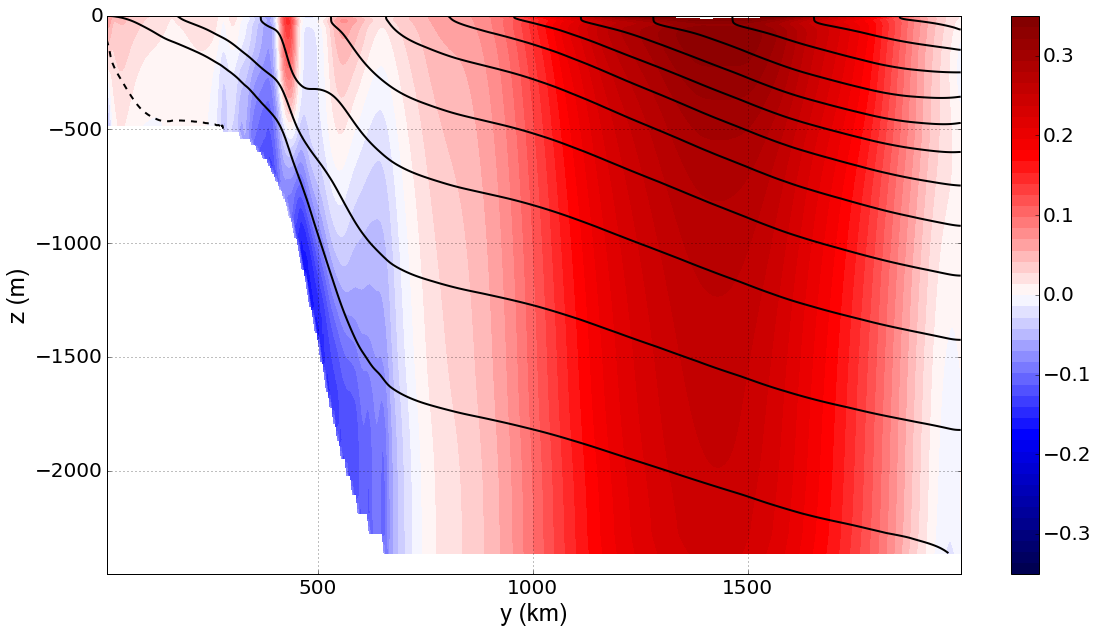

In [8]:
#temperature
temperature = zAvgData.variables['timeSeriesStats_avg_activeTracers_1_temperature'][iTime,:,:];
temperature = temperature.reshape(nY,nX,nVertLevels)
temperature = np.multiply(temperature,oceanMask)

#zonal velocity
velocityZonal = zAvgData.variables['timeSeriesStats_avg_velocityZonal_1'][iTime,:,:];
velocityZonal = velocityZonal.reshape(nY,nX,nVertLevels)
velocityZonal = np.multiply(velocityZonal,oceanMask)


velocityZonalColors = linspace(-.35, 0.35, 51)
velocityZonalTicks = [-0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3]
temperatureContours = linspace(-1.0, 6.0, 15)
print temperatureContours

minValContour = -0.2
maxValContour = 0.4
incValContour = 0.005

sumData = np.sum(temperature, axis=1);
sumData = np.divide(sumData,nX)
plotColor = sumData
sumData = np.sum(velocityZonal, axis=1);
sumData = np.divide(sumData,nX)
plotContour = sumData

plt.contourf(yPosition, zPosition, plotContour.T, cmap=plt.cm.seismic, levels=velocityZonalColors);
plt.colorbar(orientation='vertical', fraction=0.1, extend='both', ticks=velocityZonalTicks);
plt.contour(yPosition, zPosition, plotColor.T, Linewidth=20, levels=temperatureContours, colors='k', linewidths=2);
plt.xlabel("y (km)", **axis_font)
plt.ylabel('z (m)', **axis_font)
plt.grid()

savefig('zonalMeanTandUclimate.png', dpi=None, facecolor='w', edgecolor='w',
        orientation='landscape', format='png',
        transparent=True, bbox_inches=None, pad_inches=0.1,
        frameon=None)

In [9]:
#convert buoyancyMask into an ocean mask

#threshold -- this number is important
threshold = 0.01

buoyancyMaskEA = bAvgData.variables['buoyancyMaskEA'][iTime,:]
buoyancyMaskEA = buoyancyMaskEA.reshape(nY,nX,nBuoyancyLayers)
print buoyancyMaskEA.shape

oceanMask=[]
for j in range (0,nY):
    for i in range (0,nX):
        for k in range (0,nBuoyancyLayers):
            if buoyancyMaskEA[j,i,k]<threshold:
                oceanMask.append(0.0)
            else:
                oceanMask.append(1.0)

oceanMask = np.array(oceanMask)
oceanMask = oceanMask.reshape(nY,nX,nBuoyancyLayers)

(460, 200, 100)


/Users/todd/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in divide
/Users/todd/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in multiply


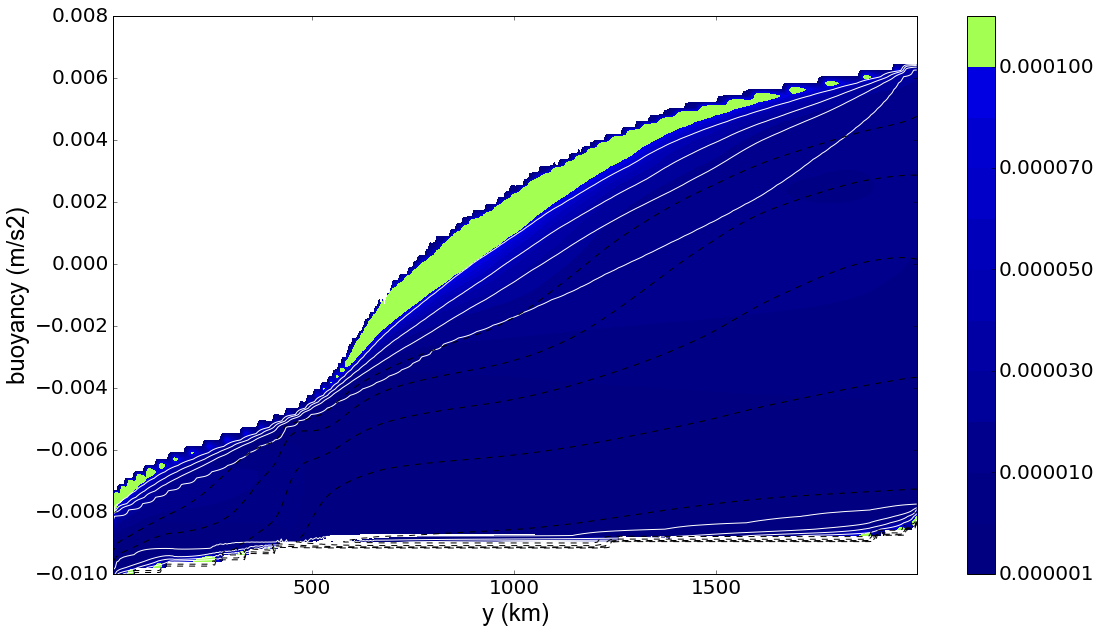

In [10]:
#sigmaEA
sigmaEA = bAvgData.variables['sigmaEA'][iTime,:,:];
sigmaEA = sigmaEA.reshape(nY,nX,nBuoyancyLayers)
N2EA = np.divide(1.0,sigmaEA)

#derive N^2
sigmaEA = np.multiply(sigmaEA,oceanMask)
N2EA = np.multiply(N2EA,oceanMask)

#height of buoyancy surfaces
heightMidBuoyCoorEA = bAvgData.variables['heightMidBuoyCoorEA'][iTime,:,:];
heightMidBuoyCoorEA = heightMidBuoyCoorEA.reshape(nY,nX,nBuoyancyLayers)
heightMidBuoyCoorEA = np.multiply(heightMidBuoyCoorEA,oceanMask)


#contours for sigma
scaling = 1e5
sigmaLevels = linspace(0.0, 5.0, 101)
sigmaLevels = np.multiply(sigmaLevels, scaling)

#contours for N2
N2Levels = [1.0e-6, 5.0e-6, 1.0e-5, 2.0e-5, 3.0e-5, 4.0e-5, 5.0e-5, 6.0e-5, 7.0e-5, 8.0e-5, 1.0e-4, 1.0e-3 ]

#contours for occurrence of buoyancy levels
maskLevels = [0.1, 0.25, 0.5, 0.95]

#contours for height
heightLevels = [-2000, -1000, -500, -250, -100]

sumData = np.sum(sigmaEA, axis=1);
sumData = np.divide(sumData,nX)
sigmaData = sumData

sumData = np.sum(N2EA, axis=1);
sumData = np.divide(sumData,nX)
N2EAData = sumData

sumData = np.sum(heightMidBuoyCoorEA, axis=1);
sumData = np.divide(sumData,nX)
heightData = sumData


#buoyancyMaskEA
buoyancyMaskEA = bAvgData.variables['buoyancyMaskEA'][iTime,:]
buoyancyMaskEA = buoyancyMaskEA.reshape(nY,nX,nBuoyancyLayers)

sumData = np.sum(buoyancyMaskEA, axis=1);
sumData = np.divide(sumData,nX)
maskData = sumData

plt.contourf(yPosition, bPosition, N2EAData.T, levels=N2Levels);
plt.colorbar();
plt.contour(yPosition, bPosition, maskData.T, levels=maskLevels, colors='w');
plt.contour(yPosition, bPosition, heightData.T, levels=heightLevels, colors='k');
plt.ylim(-0.01, 0.008)
plt.xlabel("y (km)", **axis_font)
plt.ylabel('buoyancy (m/s2)', **axis_font)

/Users/todd/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:24: RuntimeWarning: invalid value encountered in divide
/Users/todd/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:28: RuntimeWarning: invalid value encountered in divide


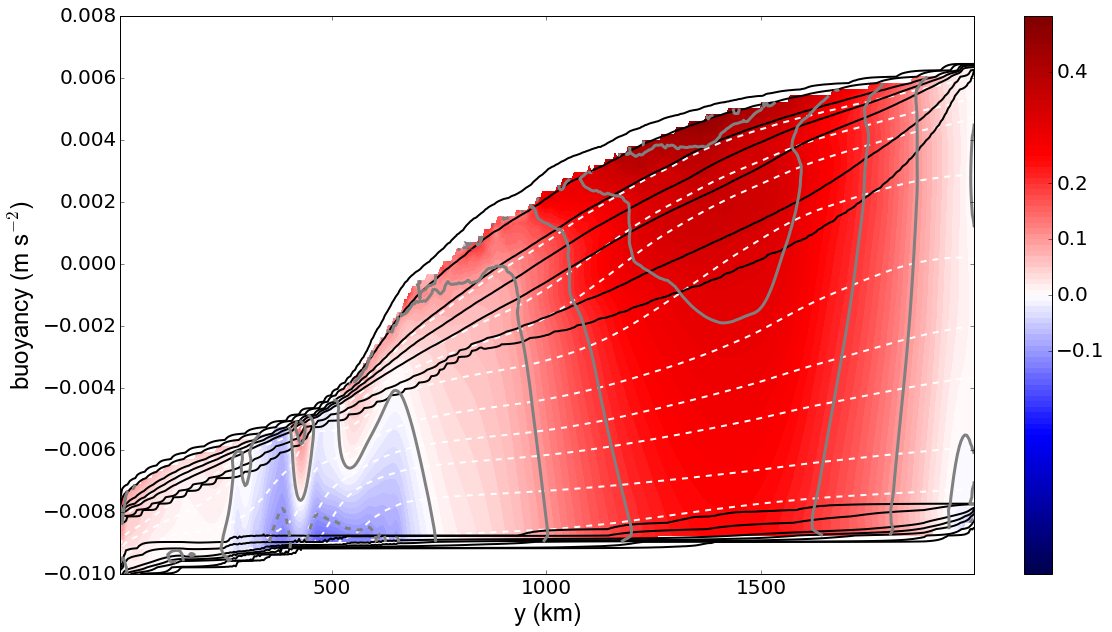

In [11]:
#uTWA
uTWA = bAvgData.variables['uTWA'][iTime,:,:];
uTWA = uTWA.reshape(nY,nX,nBuoyancyLayers)
uTWA = np.multiply(uTWA,oceanMask)

#buoyancyMaskEA
sumData_buoyancyMaskEA = np.sum(buoyancyMaskEA, axis=1);
sumData_buoyancyMaskEA = np.divide(sumData_buoyancyMaskEA,nX)
colorLevels_buoyancyMaskEA = linspace(-0.1, 1.0, 111)
contourLevels_buoyancyMaskEA = [0.001, 0.01, 0.10, 0.25, 0.50, 0.95, 0.999]

#height of buoyancy surfaces
heightMidBuoyCoorEA = bAvgData.variables['heightMidBuoyCoorEA'][iTime,:,:];
heightMidBuoyCoorEA = heightMidBuoyCoorEA.reshape(nY,nX,nBuoyancyLayers)
heightMidBuoyCoorEA = np.multiply(heightMidBuoyCoorEA,oceanMask)

scaling = 1.0e-2
uTWALevels = linspace(-50.0, 50.0, 101)
uTWATicks = [-0.1, 0, 0.1, 0.2, 0.4]
uTWALevels = np.multiply(uTWALevels, scaling)
uTWAContours = [-0.1, 0.0, 0.1, 0.2, 0.3, 0.4]

sumData_heightMidBuoyCoorEA = np.sum(heightMidBuoyCoorEA, axis=1);
sumData_heightMidBuoyCoorEA = np.divide(sumData_heightMidBuoyCoorEA,np.sum(oceanMask, axis=1))
heightContours = [-2000, -1500, -1000, -750, -500, -250, -100, -50, -10]

sumData = np.sum(uTWA, axis=1);
sumData = np.divide(sumData,np.sum(oceanMask, axis=1))
uTWAData = sumData

sumData = np.sum(buoyancyMaskEA, axis=1);
sumData = np.divide(sumData,nX)
maskData = sumData

plt.contourf(yPosition, bPosition, uTWAData.T, cmap=plt.cm.seismic, levels=uTWALevels);
plt.colorbar(orientation='vertical', fraction=0.1, extend='both', ticks=uTWATicks);
plt.contour(yPosition, bPosition, sumData_heightMidBuoyCoorEA.T, levels=heightContours, colors='white', linewidths=2);
plt.contour(yPosition, bPosition, sumData_buoyancyMaskEA.T, levels=contourLevels_buoyancyMaskEA, colors='black', linewidths=2);
plt.contour(yPosition, bPosition, uTWAData.T, levels=uTWAContours, colors='gray', linewidths=3);
plt.ylim(-0.01, 0.008)
plt.xlabel("y (km)", **axis_font)
plt.ylabel('buoyancy (m s$^{-2}$)', **axis_font)

#currentAxis = plt.gca()
#currentAxis.add_patch(Rectangle((boxRange_xAxisMin, boxRange_yAxisMin), \
#boxRange_xAxisMax-boxRange_xAxisMin, boxRange_yAxisMax-boxRange_yAxisMin, \
#                                fill=False, edgecolor="black", linewidth=3))

savefig('twaUandFoEandZ.png', dpi=None, facecolor='w', edgecolor='w',
        orientation='landscape', format='png',
        transparent=True, bbox_inches=None, pad_inches=0.1,
        frameon=None)

/Users/todd/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in divide
/Users/todd/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:33: RuntimeWarning: divide by zero encountered in divide
/Users/todd/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:33: RuntimeWarning: invalid value encountered in divide


(460, 200, 100)


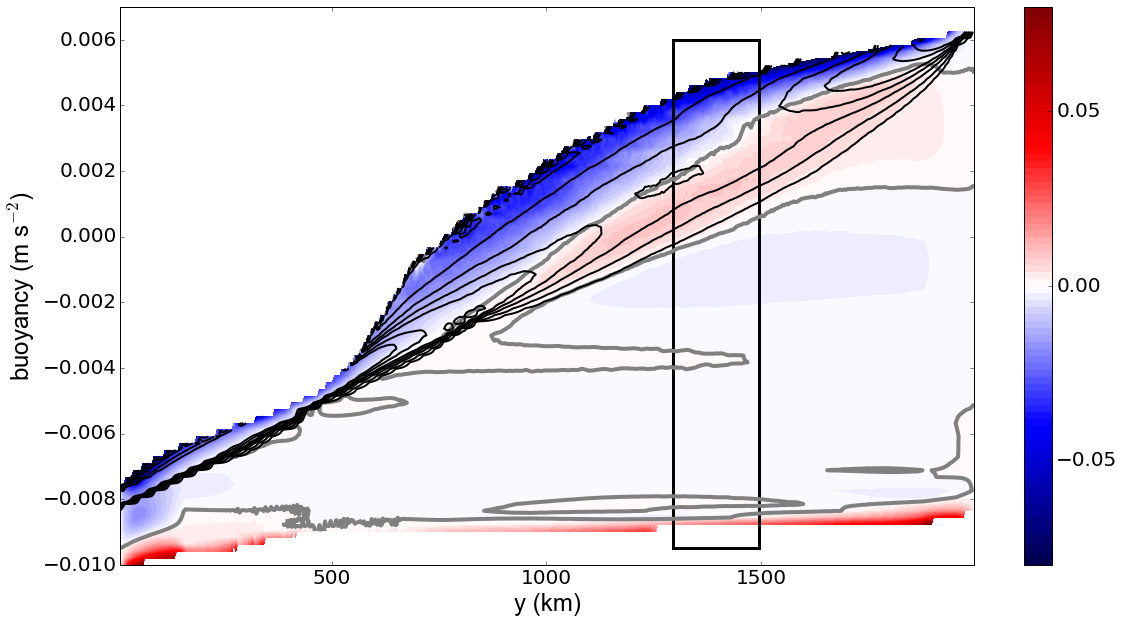

In [12]:
#vTWA
vTWA = bAvgData.variables['vTWA'][iTime,:,:];
vTWA = vTWA.reshape(nY,nX,nBuoyancyLayers)
vTWA = np.multiply(vTWA,oceanMask)

scaling = 1.0e-2
vTWALevels = linspace(-8.0, 8.0, 81)
vTWATicks = [-0.05, 0, 0.05]
vTWALevels = np.multiply(vTWALevels, scaling)
vTWAContours = [0.0]

sumData = np.sum(vTWA, axis=1);
sumData = np.divide(sumData,np.sum(oceanMask, axis=1))
vTWAData = sumData

#find how often a given layer is at the surface
atSurface = zeros_like(buoyancyMaskEA)

#compute frequency at surface by comparing buoyancy mask at adjacent levels
for iBuoyancy in range(0,nBuoyancyLayers-1):
    atSurface[:,:,iBuoyancy]=buoyancyMaskEA[:,:,iBuoyancy+1]-buoyancyMaskEA[:,:,iBuoyancy]
    
#eliminate values at outcropping at bottom of domain
workZeros = zeros_like(atSurface)
atSurface = np.where(atSurface>0, atSurface, workZeros)
print atSurface.shape

#mask to eliminate infrequent events
#atSurface = np.multiply(atSurface,oceanMask)

#sum
sumData_atSurface = np.sum(atSurface, axis=1);
sumData_atSurface = np.divide(sumData_atSurface,np.sum(oceanMask, axis=1))
atSurfaceColors = linspace(0.0, 0.1, 101)
atSurfaceContours = [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2]

plt.contourf(yPosition, bPosition, vTWAData.T, cmap=plt.cm.seismic, levels=vTWALevels);
plt.colorbar(orientation='vertical', fraction=0.1, ticks=vTWATicks);
plt.contour(yPosition, bPosition, vTWAData.T,levels=vTWAContours, colors='gray', linewidths=4);
plt.contour(yPosition, bPosition, sumData_atSurface.T, levels=atSurfaceContours, colors='black', linewidths=2);
plt.ylim(-0.01, 0.007)
plt.xlabel("y (km)", **axis_font)
plt.ylabel('buoyancy (m s$^{-2}$)', **axis_font)

currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((boxRange_xAxisMin, boxRange_yAxisMin), \
                                boxRange_xAxisMax-boxRange_xAxisMin, boxRange_yAxisMax-boxRange_yAxisMin, \
                                fill=False, edgecolor="black", linewidth=3))

savefig('twaVandFaSandBox.png', dpi=None, facecolor='w', edgecolor='w',
        orientation='landscape', format='png',
        transparent=True, bbox_inches=None, pad_inches=0.1,
        frameon=None)

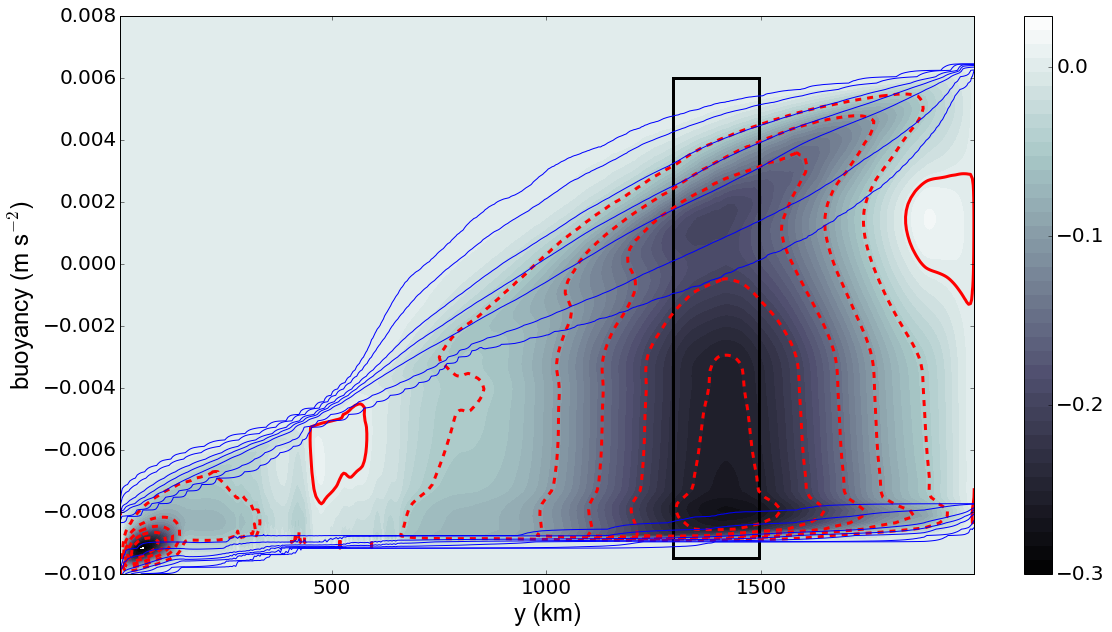

In [13]:
#vertical flux of zonal momentum
EPFT31 = bAvgData.variables['EPFT'][iTime,:,:,0,2];
EPFT31 = EPFT31.reshape(nY,nX,nBuoyancyLayers)

#convert flux vector to stress
config_density0 = 1026.0
# m2 * kg    kg      N
# s2 * m3   m s2     m2
EPFT31 = EPFT31 * config_density0

sigmaEA = bAvgData.variables['sigmaEA'][iTime,:,:];
sigmaEA = sigmaEA.reshape(nY,nX,nBuoyancyLayers)

EPFT31 = numpy.multiply(EPFT31,sigmaEA)

EPFT31Levels = linspace(-0.3, 0.03, 41)
EPFT31Ticks = [-0.3, -0.2, -0.1, 0]
EPFT31Contours = [-0.25, -0.2, -0.15, -0.1, -0.05, 0.0001]

sumData = np.sum(EPFT31, axis=1);
sumData = np.divide(sumData,nX)
sumData_EPFT31 = sumData  

plt.contourf(yPosition, bPosition, sumData_EPFT31.T, cmap=plt.cm.bone, levels=EPFT31Levels);
plt.colorbar(orientation='vertical', fraction=0.1, ticks=EPFT31Ticks);
plt.contour(yPosition, bPosition, sumData_EPFT31.T, levels=EPFT31Contours, colors='red', linewidths=3);
plt.contour(yPosition, bPosition, sumData_buoyancyMaskEA.T, levels=contourLevels_buoyancyMaskEA, colors='blue', linewidths=1);
plt.ylim(-0.01, 0.008)
plt.xlabel("y (km)", **axis_font)
plt.ylabel('buoyancy (m s$^{-2}$)', **axis_font)

currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((boxRange_xAxisMin, boxRange_yAxisMin), \
                                boxRange_xAxisMax-boxRange_xAxisMin, boxRange_yAxisMax-boxRange_yAxisMin, \
                                fill=False, edgecolor="black", linewidth=3))

savefig('verticalFluxZonalMomentumBSpace.png', dpi=None, facecolor='w', edgecolor='w',
        orientation='landscape', format='png',
        transparent=True, bbox_inches=None, pad_inches=0.1,
        frameon=None)

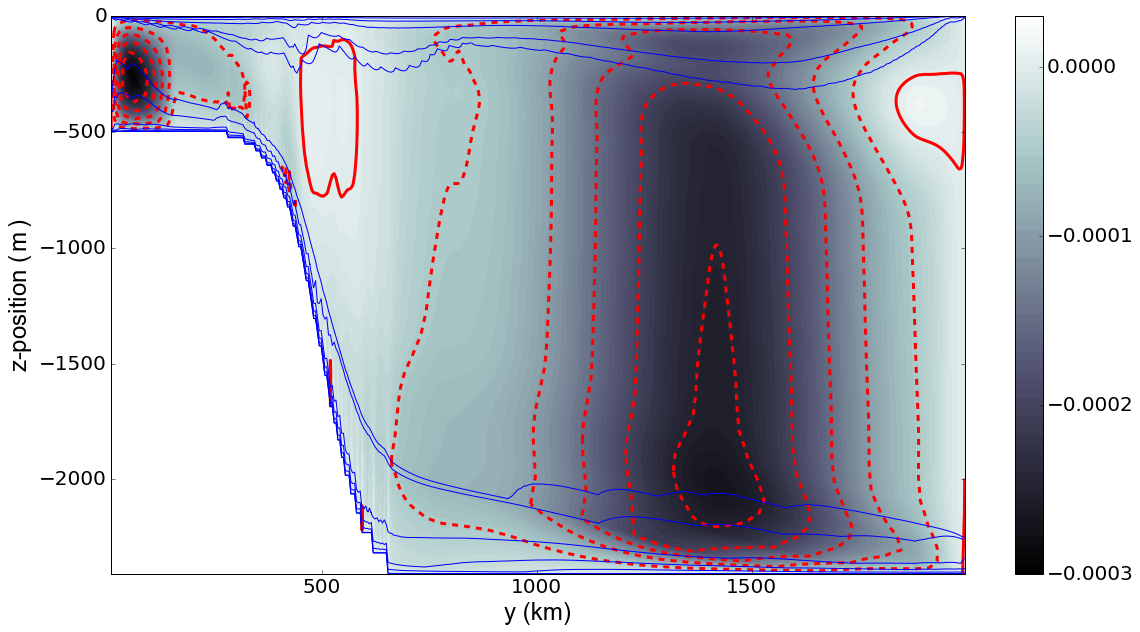

In [14]:
#
#map vertical flux of zonal momentum to z-space
#
#vertical flux of zonal momentum
EPFT31 = bAvgData.variables['EPFT'][iTime,:,:,0,2];
EPFT31 = EPFT31.reshape(nY,nX,nBuoyancyLayers)

#sigmaEA
sigmaEA = bAvgData.variables['sigmaEA'][iTime,:,:];
sigmaEA = sigmaEA.reshape(nY,nX,nBuoyancyLayers)

#scale by thickness
EPFT31 = np.multiply(EPFT31, sigmaEA)

#height of buoyancy surfaces
heightMidBuoyCoorEA = bAvgData.variables['heightMidBuoyCoorEA'][iTime,:,:];
heightMidBuoyCoorEA = heightMidBuoyCoorEA.reshape(nY,nX,nBuoyancyLayers)

sumData = np.sum(EPFT31, axis=1);
sumData = np.divide(sumData,nX)
sumData_EPFT31 = sumData  

sumData = np.sum(heightMidBuoyCoorEA, axis=1);
sumData = np.divide(sumData,nX)
pData = sumData

EPFT31Levels = linspace(-0.0003, 0.00003, 61)
EPFT31Ticks = [-0.0003, -0.0002, -0.0001, 0]
EPFT31Contours = [-0.00025, -0.0002, -0.00015, -0.0001, -0.00005, 0.0000001]
#EPFT31Contours = linspace(-0.00030, 0, 51)

yMap=zeros((nY,nBuoyancyLayers))
zMap=zeros((nY,nBuoyancyLayers))
for j in range(0,nY):
    for k in range(0,nBuoyancyLayers):
        yMap[j,k]=yPosition[j]
        zMap[j,k]=pData[j,k]
        
plt.contourf(yMap, zMap, sumData_EPFT31, cmap=plt.cm.bone, levels=EPFT31Levels);
plt.colorbar(orientation='vertical', fraction=0.1, ticks=EPFT31Ticks);
plt.contour(yMap, zMap, sumData_EPFT31, levels=EPFT31Contours, colors='red', linewidths=3);
plt.contour(yMap, zMap, sumData_buoyancyMaskEA, levels=contourLevels_buoyancyMaskEA, colors='blue', linewidths=1);
plt.xlabel("y (km)", **axis_font)
plt.ylabel('z-position ($ \, $m$ \, $)', **axis_font)

savefig('verticalFluxZonalMomentumZSpace.png', dpi=None, facecolor='w', edgecolor='w',
        orientation='landscape', format='png',
        transparent=True, bbox_inches=None, pad_inches=0.1,
        frameon=None)

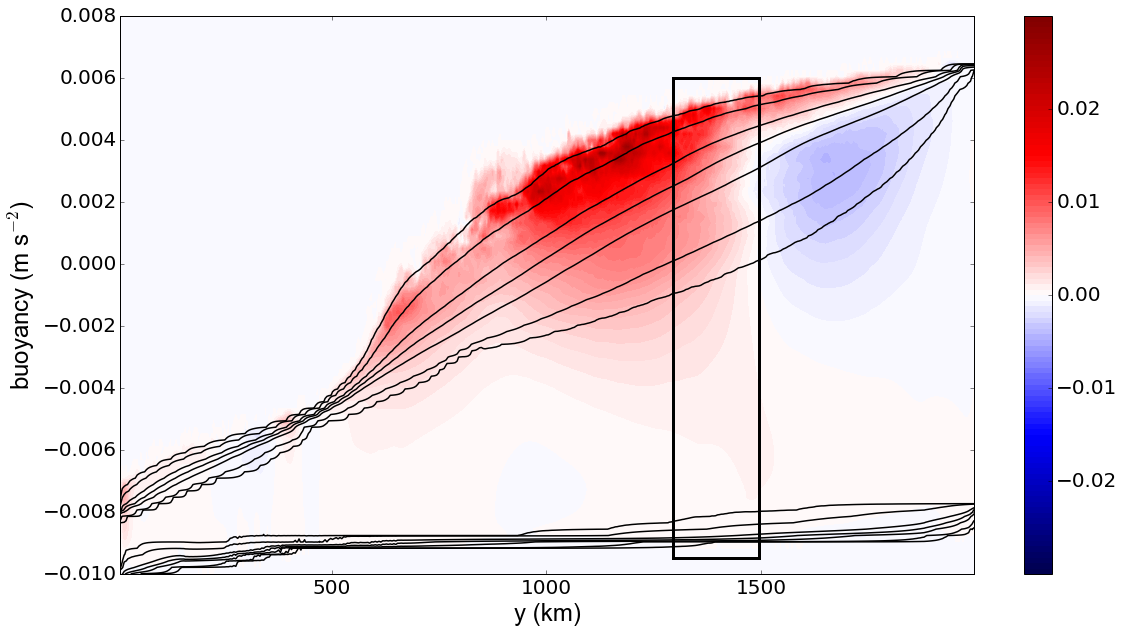

In [15]:
#meridional flux of zonal momentum
EPFT21 = bAvgData.variables['EPFT'][iTime,:,:,0,1];
EPFT21 = EPFT21.reshape(nY,nX,nBuoyancyLayers)

EPFT21Levels = linspace(-0.03, 0.03, 101)
EPFT21Contours = [-0.02, -0.01, 0, 0.01, 0.02]


maskLevels = [0.001, 0.01, 0.1, 0.25, 0.5, 0.95]

sumData = np.sum(EPFT21, axis=1);
sumData = np.divide(sumData,nX)
plotDataEPFT21 = sumData

plt.contourf(yPosition, bPosition, plotDataEPFT21.T, cmap=plt.cm.seismic, levels=EPFT21Levels);
plt.colorbar(orientation='vertical', fraction=0.1, ticks=EPFT21Contours);
plt.contour(yPosition, bPosition, sumData_buoyancyMaskEA.T, levels=contourLevels_buoyancyMaskEA, colors='black', linewidths=1.5);
plt.ylim(-0.01, 0.008)
plt.xlabel("y (km)", **axis_font)
plt.ylabel('buoyancy (m s$^{-2}$)', **axis_font)

currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((boxRange_xAxisMin, boxRange_yAxisMin), \
                                boxRange_xAxisMax-boxRange_xAxisMin, boxRange_yAxisMax-boxRange_yAxisMin, \
                                fill=False, edgecolor="black", linewidth=3))

savefig('meridionalFluxZonalMomentum.png', dpi=None, facecolor='w', edgecolor='w',
        orientation='landscape', format='png',
        transparent=True, bbox_inches=None, pad_inches=0.1,
        frameon=None)

(460, 200, 100)
(460, 100)
(460,)
0.259398711958
1199.44518424


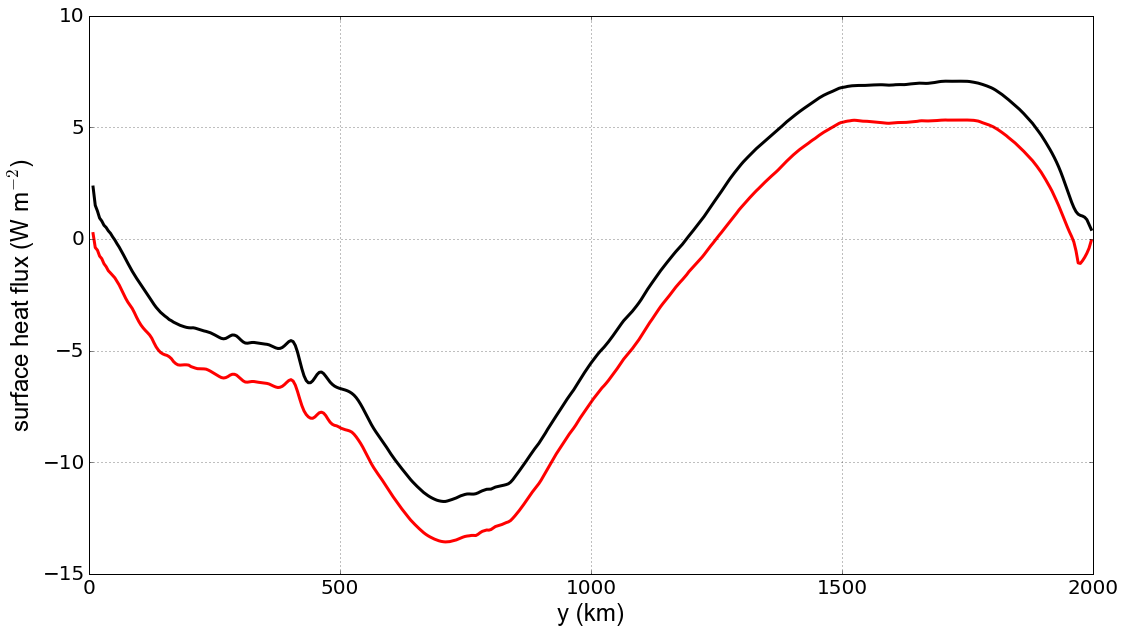

In [16]:
buoyancyForcing = zAvgData.variables['timeSeriesStats_avg_surfaceBuoyancyForcing_1'][iTime,:];
buoyancyForcing = buoyancyForcing.reshape(nY,nX)
sumData_buoyancyForcing = np.sum(buoyancyForcing, axis=1);
sumData_buoyancyForcing = np.divide(sumData_buoyancyForcing,nX)

# top row:       (m2) (C m3) (s2)  (kg)  (J)   (kg)
# bottom row:    (s3)  (kg)   (m)  (m3) (C kg)  (m3) 
heatFlux = buoyancyForcing / config_eos_linear_alpha / gravity * rho_sw * config_specific_heat_sea_water * rho_sw
sumData_heatFlux = np.sum(heatFlux, axis=1);
sumData_heatFlux = np.divide(sumData_heatFlux,nX)


#now derive surface heat from data computed in buoyancy space

#first recompute atSurface
#find how often a given layer is at the surface
atSurface = zeros_like(buoyancyMaskEA)

#compute frequency at surface by comparing buoyancy mask at adjacent levels
for iBuoyancy in range(0,nBuoyancyLayers-1):
    atSurface[:,:,iBuoyancy]=buoyancyMaskEA[:,:,iBuoyancy+1]-buoyancyMaskEA[:,:,iBuoyancy]
    
#eliminate values at outcropping at bottom of domain
workZeros = zeros_like(atSurface)
atSurface = np.where(atSurface>0, atSurface, workZeros)

#now find the temperature associated with each buoyancy layer
potentialDensityMidRef = bAvgData.variables['potentialDensityMidRef'][:]
temperatureRef = zeros_like(potentialDensityMidRef)
temperatureRef[:] = -(potentialDensityMidRef[:]-config_eos_linear_densityref)/config_eos_linear_alpha + config_eos_linear_Tref

#read in restoring temperature and piston velocity
temperatureSurfaceRestoringValue = forcingData.variables['temperatureSurfaceRestoringValue'][iTime,:]
temperatureSurfaceRestoringValue = temperatureSurfaceRestoringValue.reshape(nY,nX)

temperaturePistonVelocity = forcingData.variables['temperaturePistonVelocity'][iTime,:]
temperaturePistonVelocity = temperaturePistonVelocity.reshape(nY,nX)

workRef = zeros_like(buoyancyMaskEA)
for iBuoyancy in range(0,nBuoyancyLayers):
    workRef[:,:,iBuoyancy]=temperatureRef[iBuoyancy]

bSpaceHeatFlux = zeros_like(buoyancyMaskEA)
for iBuoyancy in range(0,nBuoyancyLayers):
    bSpaceHeatFlux[:,:,iBuoyancy] = -(workRef[:,:,iBuoyancy]-temperatureSurfaceRestoringValue[:,:])   #delta C
    bSpaceHeatFlux[:,:,iBuoyancy] = np.multiply(bSpaceHeatFlux[:,:,iBuoyancy], temperaturePistonVelocity[:,:]) #C m / s
    bSpaceHeatFlux[:,:,iBuoyancy] = bSpaceHeatFlux[:,:,iBuoyancy] * config_specific_heat_sea_water * config_density0   # C m / s * J / kg / C * kg / 3
    
bSpaceHeatFlux = np.multiply(bSpaceHeatFlux,atSurface)
print bSpaceHeatFlux.shape

sumData = np.sum(bSpaceHeatFlux, axis=1);
sumData = np.divide(sumData,nX)
sumData_bSpaceHeatFlux = sumData
print sumData_bSpaceHeatFlux.shape

sumData = np.sum(sumData_bSpaceHeatFlux,axis=1)
sumData_bSpaceHeatFlux = sumData
print sumData.shape

#plt.contourf(yPosition, bPosition, sumData_bSpaceHeatFlux.T);
#plt.colorbar();
#plt.contour(yPosition, bPosition, sumData_buoyancyMaskEA.T, levels=contourLevels_buoyancyMaskEA, colors='black', linewidths=1.5);
#plt.ylim(-0.01, 0.008)
#plt.xlabel("y (km)", **axis_font)
#plt.ylabel('buoyancy (m/s2)', **axis_font)

plt.plot(yPosition,sumData_heatFlux, color='k', linewidth=3)
plt.plot(yPosition,sumData_bSpaceHeatFlux, color='r', linewidth=3)
plt.xlabel("y (km)", **axis_font)
plt.ylabel('surface heat flux (W m$^{-2}$)', **axis_font)
plt.grid()

print sumData_heatFlux[275]
print yPosition[275]
#plt.plot(yPosition,sumData)

(460, 200)


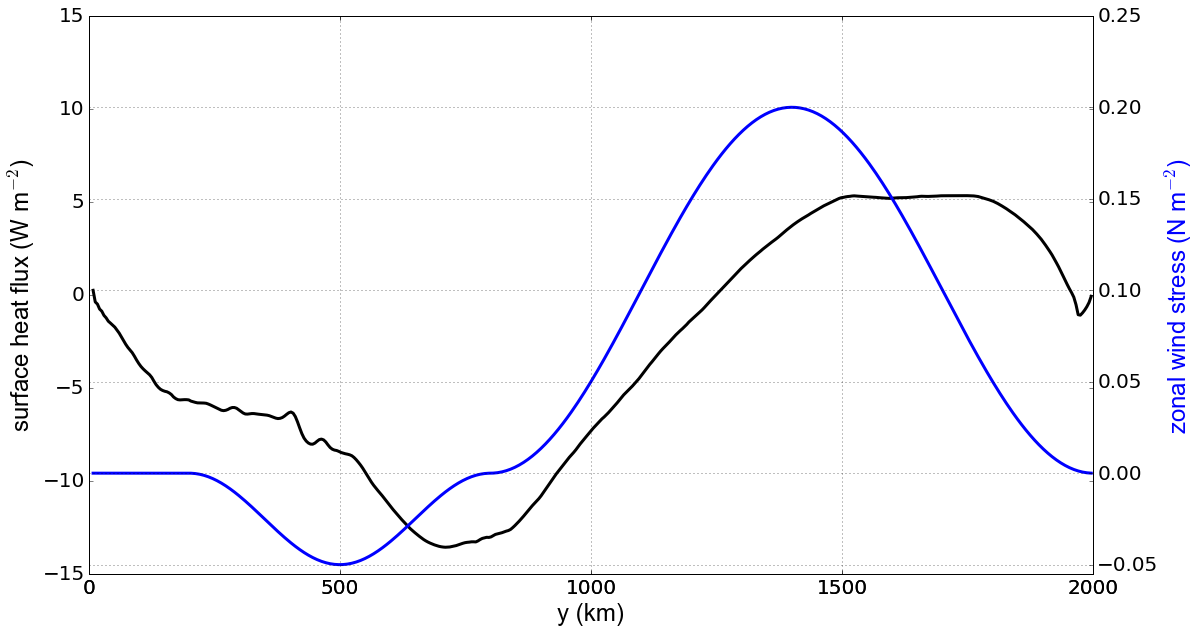

1251.40670847 0.0571931281028


In [17]:
windStressZonal = forcingData.variables['windStressZonal'][:]
windStressZonal = windStressZonal.reshape(nY,nX)
print windStressZonal.shape
sumData_windStressZonal = np.sum(windStressZonal, axis=1);
sumData_windStressZonal = np.divide(sumData_windStressZonal,nX)

# create the general figure
fig1 = figure()
 
# and the first axes using subplot populated with data 
ax1 = fig1.add_subplot(111)
line1 = ax1.plot(yPosition,sumData_bSpaceHeatFlux, color='k', linewidth=3)
ylabel('surface heat flux (W m$^{-2}$)', **axis_font)
ylim(-15, 15)

 
# now, the second axes that shares the x-axis with the ax1
ax2 = fig1.add_subplot(111, sharex=ax1, frameon=False)
line2 = ax2.plot(yPosition,sumData_windStressZonal, color='blue', linewidth=3)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ylabel("zonal wind stress (N m$^{-2}$)", color='blue', **axis_font)
xlabel("y (km)", **axis_font)
ylim(-0.055, 0.25)
plt.grid()

 
savefig('surfaceForcing.png', dpi=None, facecolor='w', edgecolor='w',
        orientation='landscape', format='png',
        transparent=True, bbox_inches=None, pad_inches=0.1,
        frameon=None)

# for the legend, remember that we used two different axes so, we need 
# to build the legend manually
show()

j=287
print yPosition[j], sumData_bSpaceHeatFlux[j]

/Users/todd/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in sqrt


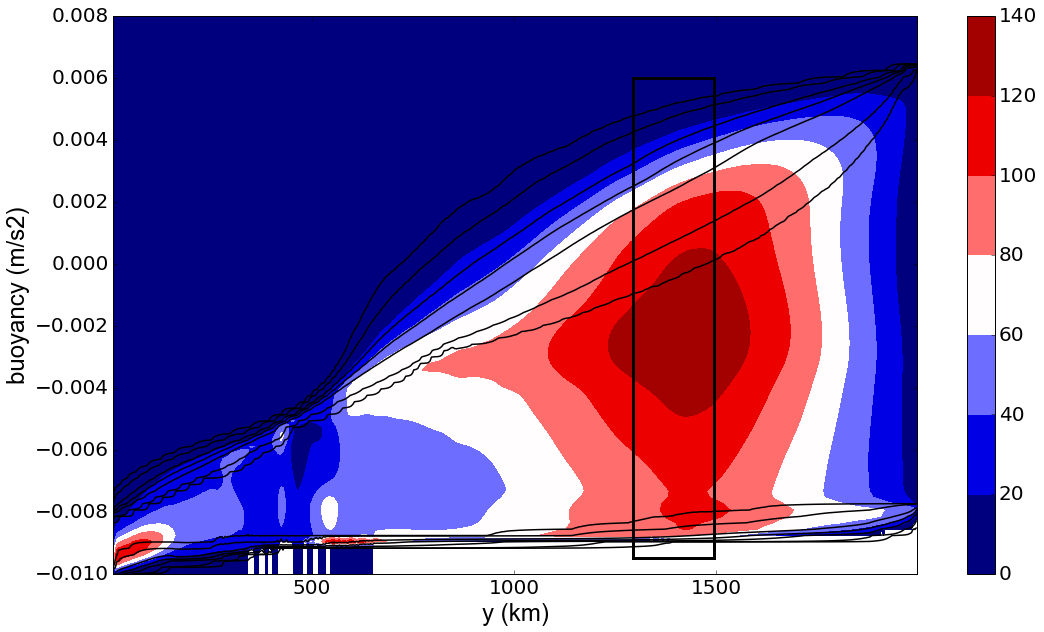

In [18]:
# eddy height squared
heightMidBuoyCoorSqEA = bAvgData.variables['heightMidBuoyCoorSqEA'][iTime,:,:];
heightMidBuoyCoorSqEA = heightMidBuoyCoorSqEA.reshape(nY,nX,nBuoyancyLayers)

heightMidBuoyCoorEA = bAvgData.variables['heightMidBuoyCoorEA'][iTime,:,:];
heightMidBuoyCoorEA = heightMidBuoyCoorEA.reshape(nY,nX,nBuoyancyLayers)

work = np.multiply(heightMidBuoyCoorEA, heightMidBuoyCoorEA)
work1 = np.subtract(heightMidBuoyCoorSqEA,work)
work1 = np.sqrt(work1)


#heightMidBuoyCoorSqEALevels = linspace(-0.03, 0.03, 101)
#heightMidBuoyCoorSqEAContours = [-0.02, -0.01, 0, 0.01, 0.02]

maskLevels = [0.001, 0.01, 0.1, 0.25, 0.5, 0.95]

sumData = np.sum(work1, axis=1);
sumData = np.divide(sumData,nX)
plotheightMidBuoyCoorSqEA = sumData

plt.contourf(yPosition, bPosition, plotheightMidBuoyCoorSqEA.T, cmap=plt.cm.seismic);
plt.colorbar(orientation='vertical');
plt.contour(yPosition, bPosition, sumData_buoyancyMaskEA.T, levels=contourLevels_buoyancyMaskEA, colors='black', linewidths=1.5);
plt.ylim(-0.01, 0.008)
plt.xlabel("y (km)", **axis_font)
plt.ylabel('buoyancy (m/s2)', **axis_font)

currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((boxRange_xAxisMin, boxRange_yAxisMin), \
                                boxRange_xAxisMax-boxRange_xAxisMin, boxRange_yAxisMax-boxRange_yAxisMin, \
                                fill=False, edgecolor="black", linewidth=3))

savefig('plotheightMidBuoyCoorSqEA.png', dpi=None, facecolor='w', edgecolor='w',
        orientation='landscape', format='png',
        transparent=True, bbox_inches=None, pad_inches=0.1,
        frameon=None)


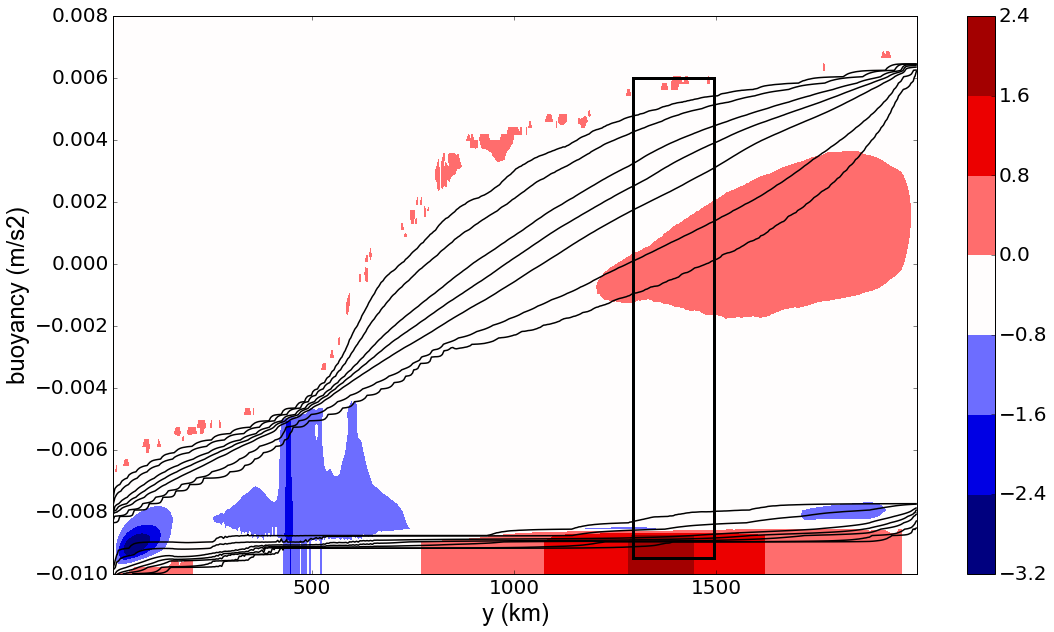

In [19]:
# meridional mass flux
vsigmaEA = rAvgData.variables['vsigmaEA'][iTime,:,:];
vsigmaEA = vsigmaEA.reshape(nY,nX,nBuoyancyLayers)

#heightMidBuoyCoorSqEALevels = linspace(-0.03, 0.03, 101)
#heightMidBuoyCoorSqEAContours = [-0.02, -0.01, 0, 0.01, 0.02]

maskLevels = [0.001, 0.01, 0.1, 0.25, 0.5, 0.95]

verticalSum = np.cumsum(vsigmaEA*db, axis=2)
sumData = np.sum(verticalSum, axis=1);
sumData = np.divide(sumData,nX)
plotvsigmaEA = sumData
#plotCumSum = cumsum(plotvsigmaEA, axis=1)

plt.contourf(yPosition, bPosition, plotvsigmaEA.T, cmap=plt.cm.seismic);
plt.colorbar(orientation='vertical');
plt.contour(yPosition, bPosition, sumData_buoyancyMaskEA.T, levels=contourLevels_buoyancyMaskEA, colors='black', linewidths=1.5);
plt.ylim(-0.01, 0.008)
plt.xlabel("y (km)", **axis_font)
plt.ylabel('buoyancy (m/s2)', **axis_font)

currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((boxRange_xAxisMin, boxRange_yAxisMin), \
                                boxRange_xAxisMax-boxRange_xAxisMin, boxRange_yAxisMax-boxRange_yAxisMin, \
                                fill=False, edgecolor="black", linewidth=3))

savefig('plotheightMidBuoyCoorSqEA.png', dpi=None, facecolor='w', edgecolor='w',
        orientation='landscape', format='png',
        transparent=True, bbox_inches=None, pad_inches=0.1,
        frameon=None)

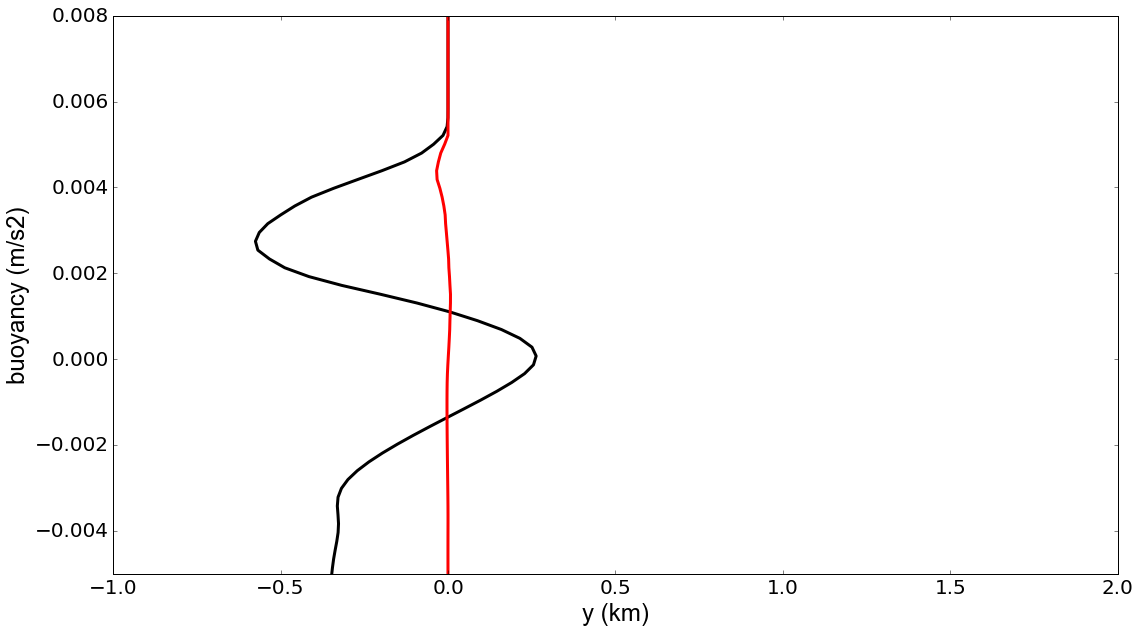

In [20]:
avg_verticalSum = zeros_like(verticalSum)
avg_verticalSum = verticalSum[index_yPositionMin:index_yPositionMax,:,:]
sumData = np.sum(np.sum(avg_verticalSum, axis=1), axis=0)
sumData = np.divide(sumData,nX*(index_yPositionMax-index_yPositionMin))
avg_verticalSum = sumData

avg_vTWA = zeros_like(vTWA)
avg_vTWA = vTWA[index_yPositionMin:index_yPositionMax,:,:]
sumData = np.sum(np.sum(avg_vTWA, axis=1), axis=0)
sumData = np.divide(sumData,nX*(index_yPositionMax-index_yPositionMin))
avg_vTWA = sumData

#plt.plot(avg_buoyancyMaskEA, bPosition, color='black', linewidth=3)
plt.plot(avg_verticalSum, bPosition, color='black', linewidth=3)
plt.plot(avg_vTWA, bPosition, color='red', linewidth=3)
plt.ylim(-0.005, 0.008)
plt.xlabel("y (km)", **axis_font)
plt.ylabel('buoyancy (m/s2)', **axis_font)

/Users/todd/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:49: RuntimeWarning: invalid value encountered in divide


1190.7849302 -0.135329463807


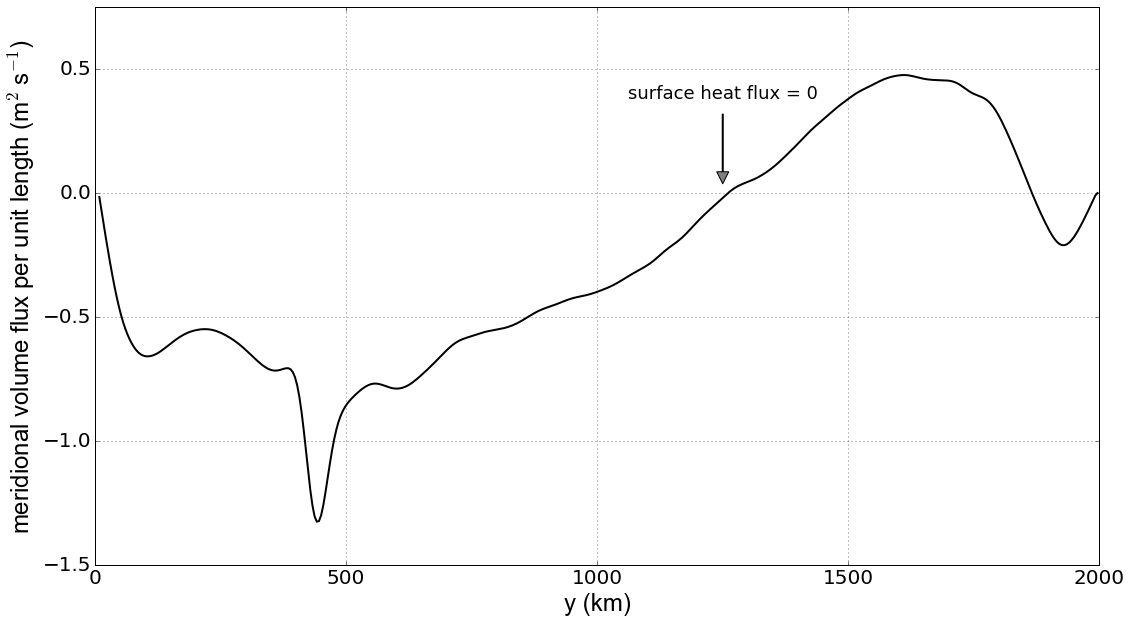

In [21]:
#get meridional flux
vsigmaEA = rAvgData.variables['vsigmaEA'][iTime,:,:];
vsigmaEA = vsigmaEA.reshape(nY,nX,nBuoyancyLayers)

#scale with buoyancy thickness
vsigmaEA = np.multiply(vsigmaEA,db)

#build work arrays of 0/1
workZeros = zeros_like(vsigmaEA)
workOnes = ones_like(vsigmaEA)

#find mass flux in surface layer
atSurfaceMask = zeros_like(atSurface)
atSurfaceMask = np.where(atSurface>0, atSurface, workZeros)

#produce mask of surface layer
surfaceLayerMask = np.where(atSurface>1.0e-10, workOnes, workZeros)
surfaceLayerMask = np.where(buoyancyMaskEA>1.0e-6, surfaceLayerMask, workZeros)

#find surface layer thickness
surfaceLayerThickness = zeros_like(vsigmaEA)
surfaceLayerThickness = np.multiply(sigmaEA,db)
surfaceLayerThickness = np.multiply(surfaceLayerThickness,surfaceLayerMask)

#find average buoyancy in the surface layer, dz weighted
surfaceLayerBuoyancy = zeros_like(vsigmaEA)
for i in range(0,nX-1):
    for j in range(0,nY-1):
        surfaceLayerBuoyancy[j,i,:]=np.multiply(surfaceLayerThickness[j,i,:], bPosition[:])
        
#mask sfcLayerBuoyancy with surfaceLayerMask
surfaceLayerBuoyancy = np.multiply(surfaceLayerBuoyancy,surfaceLayerMask)

#mask meridional flux with surface mask (as units of m2/s)
surfaceFlux = np.multiply(vsigmaEA,surfaceLayerMask)

#sum surfaceFlux, surfaceLayerThickness and surfaceLayerBuoyancy
surfaceFlux = np.cumsum(surfaceFlux,axis=2)
surfaceLayerThickness = np.cumsum(surfaceLayerThickness,axis=2)
surfaceLayerBuoyancy = np.cumsum(surfaceLayerBuoyancy,axis=2)

#pull out the summed value
surfaceFluxVSum = surfaceFlux[:,:,nBuoyancyLayers-1]
surfaceLayerThicknessVSum = surfaceLayerThickness[:,:,nBuoyancyLayers-1]
surfaceLayerBuoyancyVSum = surfaceLayerBuoyancy[:,:,nBuoyancyLayers-1]

#normalize
#surfaceFluxVSum = np.divide(surfaceFluxVSum,surfaceLayerThicknessVSum)
surfaceLayerBuoyancyVSum = np.divide(surfaceLayerBuoyancyVSum,surfaceLayerThicknessVSum)

#sum in x
avg_surfaceFluxVSum = zeros_like(surfaceFluxVSum)
sumData = np.sum(surfaceFluxVSum, axis=1)
sumData = np.divide(sumData,nX)
avg_surfaceFluxVSum = sumData

#sum in x
avg_surfaceLayerThicknessVSum = zeros_like(surfaceLayerThicknessVSum)
sumData = np.sum(surfaceLayerThicknessVSum, axis=1)
sumData = np.divide(sumData,nX)
avg_surfaceLayerThicknessVSum = sumData

#sum in x
avg_surfaceLayerBuoyancyVSum = zeros_like(surfaceLayerBuoyancyVSum)
sumData = np.sum(surfaceLayerBuoyancyVSum, axis=1)
sumData = np.divide(sumData,nX)
avg_surfaceLayerBuoyancyVSum = sumData

#scale avg_surfaceLayerBuoyancyVSum to units of temperature
avg_surfaceLayerTemperature = avg_surfaceLayerBuoyancyVSum * config_density0 / gravity / config_eos_linear_alpha

data1 = zeros_like(avg_surfaceLayerThicknessVSum)
data1 = avg_surfaceLayerThicknessVSum
data2 = zeros_like(avg_surfaceFluxVSum)
data2 = avg_surfaceFluxVSum

dataWork1 = zeros_like(data1)
dataWork1 = data1
dataWork2 = zeros_like(data2)
dataWork2 = data2

for i in range (0,25):
    data1 = dataWork1
    data2 = dataWork2
    for j in range(1,nY-2):
        dataWork1[j] = (data1[j-1]+2*data1[j]+data1[j+1])/4.0
        dataWork2[j] = (data2[j-1]+2*data2[j]+data2[j+1])/4.0

avg_surfaceLayerThicknessVSum = dataWork1
avg_surfaceFluxVSum = dataWork2

#subplot(5,1,1)
#plt.plot(yPosition,avg_surfaceLayerThicknessVSum,linewidth=2,color='black')
#plt.grid()
#xlabel("y(km)", color='black', **axis_font)

#subplot(5,1,2)
plt.plot(yPosition,avg_surfaceFluxVSum,linewidth=2,color='black')
plt.grid()
xlabel("y (km)", color='black', **axis_font)
plt.ylim(-1.5, 0.75)
plt.ylabel('meridional volume flux per unit length (m$^2$ s$^{-1}$)', **axis_font)

plt.annotate('surface heat flux = 0', fontsize=18,
             xy=(1250.0, 0.00), xycoords='data',
             xytext=(1250.0, 0.4), textcoords='data',
             horizontalalignment='center', verticalalignment='center',
             arrowprops=dict(facecolor='gray', shrink=0.1, width=1) )

#savefig('plotSurfaceVolumeFlux.png', dpi=None, facecolor='w', edgecolor='w',
#        orientation='landscape', format='png',
#        transparent=True, bbox_inches=None, pad_inches=0.1,
#        frameon=None)

j=273
print yPosition[j], avg_surfaceFluxVSum[j]

#subplot(5,1,3)
#plt.plot(yPosition,avg_surfaceLayerBuoyancyVSum,linewidth=2,color='black')
#plt.grid()
#xlabel("y(km)", color='black', **axis_font)

#subplot(5,1,4)
#plt.plot(yPosition,avg_surfaceLayerTemperature,linewidth=2,color='black')
#plt.grid()
#xlabel("y(km)", color='black', **axis_font)

#subplot(5,1,5)
#plt.plot(yPosition,avg_surfaceLayerHeatTransport,linewidth=2,color='black')
#plt.grid()
#xlabel("y(km)", color='black', **axis_font)

(460, 200)


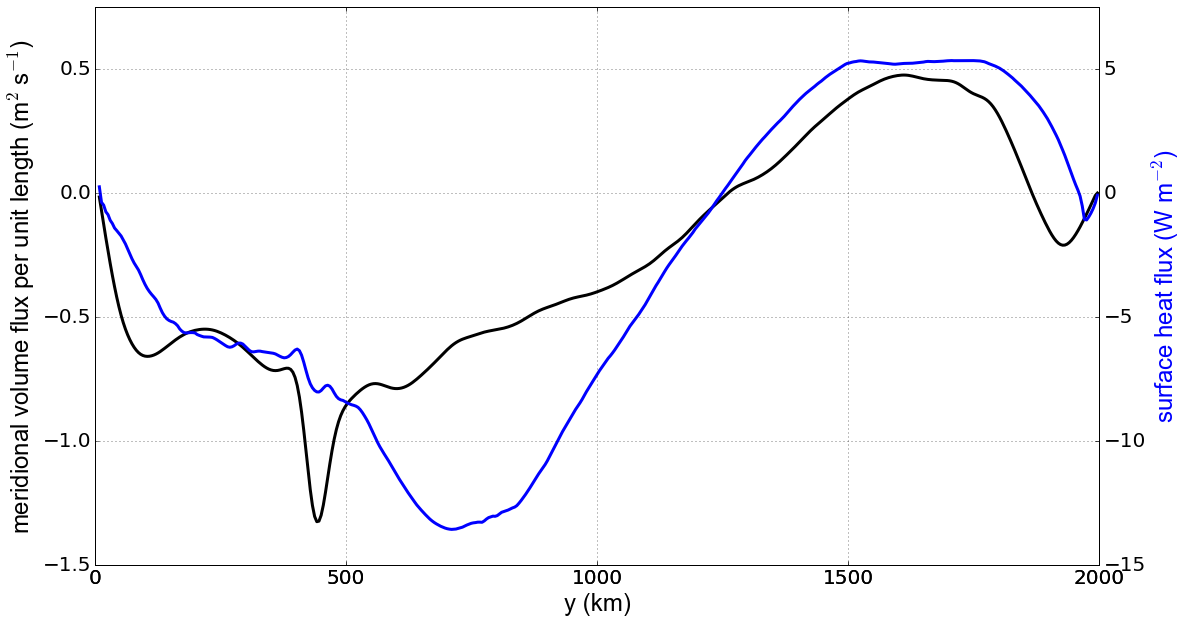

1251.40670847 0.0571931281028


In [55]:
windStressZonal = forcingData.variables['windStressZonal'][:]
windStressZonal = windStressZonal.reshape(nY,nX)
print windStressZonal.shape
sumData_windStressZonal = np.sum(windStressZonal, axis=1);
sumData_windStressZonal = np.divide(sumData_windStressZonal,nX)

# create the general figure
fig1 = figure()
 
# and the first axes using subplot populated with data 
ax1 = fig1.add_subplot(111)
line1 = ax1.plot(yPosition,avg_surfaceFluxVSum, color='black', linewidth=3)
ylabel('meridional volume flux per unit length (m$^2$ s$^{-1}$)', color='black', **axis_font)
plt.ylim(-1.5, 0.75)

 
# now, the second axes that shares the x-axis with the ax1
ax2 = fig1.add_subplot(111, sharex=ax1, frameon=False)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
line2 = ax2.plot(yPosition,sumData_bSpaceHeatFlux, color='blue', linewidth=3)
ylabel('surface heat flux (W m$^{-2}$)', color='blue', **axis_font)
plt.ylim(-15, 7.5)
xlabel("y (km)", color='black', **axis_font)


plt.grid()

savefig('plotSurfaceVolumeFlux.png', dpi=None, facecolor='w', edgecolor='w',
        orientation='landscape', format='png',
        transparent=True, bbox_inches=None, pad_inches=0.1,
        frameon=None)

# for the legend, remember that we used two different axes so, we need 
# to build the legend manually
show()

j=287
print yPosition[j], sumData_bSpaceHeatFlux[j]




/Users/todd/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in divide


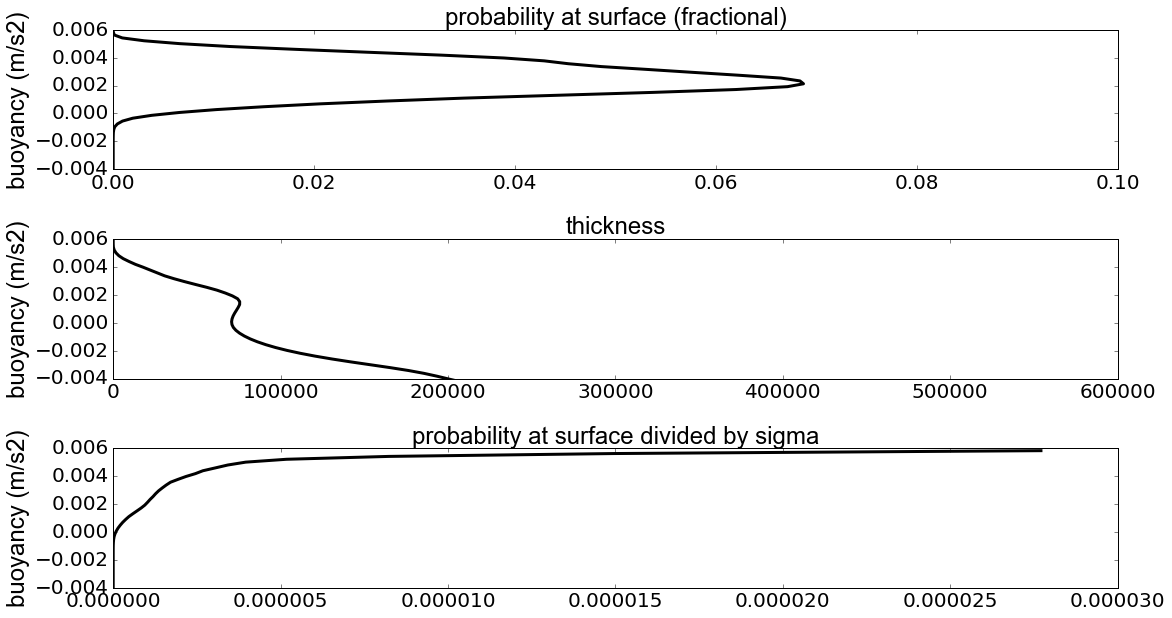

In [54]:
avg_atSurface = zeros_like(atSurface)
avg_atSurface = atSurface[index_yPositionMin:index_yPositionMax,:,:]
sumData = np.sum(np.sum(avg_atSurface, axis=1), axis=0)
sumData = np.divide(sumData,nX*(index_yPositionMax-index_yPositionMin))
avg_atSurface = sumData

avg_sigmaEA = zeros_like(sigmaEA)
avg_sigmaEA = sigmaEA[index_yPositionMin:index_yPositionMax,:,:]
sumData = np.sum(np.sum(avg_sigmaEA, axis=1), axis=0)
sumData = np.divide(sumData,nX*(index_yPositionMax-index_yPositionMin))
avg_sigmaEA = sumData

#ratio
ratio = np.divide(avg_atSurface, avg_sigmaEA)

subplot(3,1,1)
plt.plot(avg_atSurface, bPosition, color='black', linewidth=3)
plt.xlim(0.0, 0.1)
plt.ylim(-0.004, 0.006)
plt.title("probability at surface (fractional)", **axis_font)
plt.ylabel('buoyancy (m/s2)', **axis_font)

subplot(3,1,2)
plt.plot(avg_sigmaEA, bPosition, color='black', linewidth=3)
#plt.xlim(0.0, 0.1)
plt.ylim(-0.004, 0.006)
plt.ylabel('buoyancy (m/s2)', **axis_font)
plt.title("thickness", **axis_font)

subplot(3,1,3)
plt.plot(ratio, bPosition, color='black', linewidth=3)
#plt.xlim(0.0, 0.1)
plt.ylim(-0.004, 0.006)
plt.title("probability at surface divided by sigma", **axis_font)
plt.ylabel('buoyancy (m/s2)', **axis_font)

plt.subplots_adjust(hspace=0.5)

savefig('responsePlot.png', dpi=None, facecolor='w', edgecolor='w',
        orientation='landscape', format='png',
        transparent=True, bbox_inches=None, pad_inches=0.1,
        frameon=None)


In [23]:
plt.contourf(yPosition, bPosition, cumsum_sfcLayerBuoyancy.T, cmap=plt.cm.viridis);
plt.colorbar(orientation='vertical');
plt.contour(yPosition, bPosition, sumData_buoyancyMaskEA.T, levels=contourLevels_buoyancyMaskEA, colors='black', linewidths=1.5);
plt.ylim(-0.01, 0.008)
plt.xlabel("y (km)", **axis_font)
plt.ylabel('buoyancy (m/s2)', **axis_font)

NameError: name 'cumsum_sfcLayerBuoyancy' is not defined

In [ ]:
data = zeros_like(avg_surfaceFlux[:,99])
data = avg_surfaceFlux[:,99]
print data.shape

dataWork = zeros_like(data)
dataWork[:] = data[:]

dataNew = zeros_like(data)
for i in range (0,20):
    dataNew = dataWork
    for j in range(1,457):
        dataWork[j] = (dataNew[j-1]+2*dataNew[j]+dataNew[j+1])/4.0
        
print data.shape
meridsurfaceFlux=dataWork
plt.plot(yPosition,dataWork,linewidth=4,color='black')
plt.grid()
xlabel("y(km)", color='black', **axis_font)
ylabel("meridional surface layer flux ($m^2/s$)", **axis_font)
ylim(-1.5,1.0)

plt.annotate('zero surface buoyancy forcing', fontsize=18,
             xy=(1200.0, 0.00), xycoords='data',
             xytext=(1250.0, -0.90), textcoords='data',
             horizontalalignment='left', verticalalignment='left',
             arrowprops=dict(facecolor='gray', shrink=0.1, width=4) )
 
savefig('surfaceLayerFlux.png', dpi=None, facecolor='w', edgecolor='w',
        orientation='landscape', format='png',
        transparent=True, bbox_inches=None, pad_inches=0.1,
        frameon=None)

In [ ]:
data = zeros_like(dysfcLayerBuoyancy)
data = dysfcLayerBuoyancy
print data.shape

dataWork = zeros_like(data)
dataWork[:] = data[:]

dataNew = zeros_like(data)
for i in range (0,20):
    dataNew = dataWork
    for j in range(1,nY-2):
        dataWork[j] = (dataNew[j-1]+2*dataNew[j]+dataNew[j+1])/4.0
        
dysfcLayerBuoyancy=dataWork
dysfcLayerBuoyancy[0:10]=dysfcLayerBuoyancy[3]
dysfcLayerBuoyancy[nY-9:nY]=dysfcLayerBuoyancy[nY-10]

meridHeat = np.multiply(dysfcLayerBuoyancy,meridsurfaceFlux)
meridHeat = meridHeat * config_eos_linear_alpha * config_specific_heat_sea_water / gravity

plt.plot(yPosition,meridHeat,linewidth=4,color='black')
plt.grid()
xlabel("y(km)", color='black', **axis_font)
#ylabel("meridional surface layer flux ($m^2/s$)", **axis_font)
#ylim(-1.5,1.0)


# m / s3 * ( s2 / m ) = 1 / s  (1/gravity)
# 1 / s * ( kg / m3 ) = kg / s / m3 (density)
# kg / s / m3 * (J / kg / C) = J / C / s  (cp)
# J / C / s * (kg / m3 / C) = J kg / s / m3  (alpha)
#J kg / s / m3 * ( m3 / kg) = J / s  (1 / density)
